# MDM imaging analysis

In [130]:
# load modules
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker
import nilearn.plotting as plotting
from nilearn.image import mean_img
import pickle
import pandas as pd
import seaborn as sns 

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


## Rename task number to run number.

In [10]:
data_root = '/home/rj299/project/mdm_analysis/data_rename'

In [101]:
# functions for changing file names

# rename all files by adding run number determined by session and task number during scanning
def addRunNum(directory): 
    """ Add scan run numbers to file name
    
    Parameters
    --------------
    directory: directory for a subject, contains data for all runs
    
    """
    os.chdir(directory)
    
    # get sorted task number from the directory
    task_num_all = getTaskNum(directory)
    
    # add run number and rename
    for filename in os.listdir(directory):
        # get task number
        task_num = int(filename.split('_task-task')[1].split('_')[0])
        
        # get the run number based on all the task number in the directory
        run_count = task_num_all.index(task_num) + 1

        
        filename_new = filename.split('_task-task%s' %task_num)[0] + '_run-%s' %run_count + filename.split('_task-task%s' %task_num)[1]

        os.rename(filename, filename_new)  
        print(filename_new)

# get all task numbers for ses one
def getTaskNum(directory):
    """ Get all the task number for a session
     
    Parameters
    -----------------
    directory: data directory for a subject
    
    Return
    -----------------
    task_num: sorted task number for each session
    """
    file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
    task_num = []
    
    for file in file_ses:
        task_id = file.split('_task-task')[1].split('_space')[0]
        task_num.append(int(task_id))
    
    task_num.sort()
    
    return task_num

In [112]:
# get all subjects folder
sub_fold = glob.glob(data_root + '/sub-*')

# get all subject id
sub_num = [] 
for fold in sub_fold:
    sub_id = fold.split('sub-')[1]
    sub_num.append(int(sub_id))
    
sub_num.sort()
print('All subjects included in analysis:', sub_num)

All subjects included in analysis: [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 2651, 2652, 2653, 2655, 2656, 2657, 2659, 2660, 2662, 2663, 2664, 2665, 2666]


The following two sections change the file names and only need running ONCE.

In [108]:
# rename files and add run number in the file name
# needs running only ONCE

# for fold in sub_fold:
#     if fold != '/home/rj299/project/mdm_analysis/data_rename/sub-2582':
#         addRunNum(fold)

In [114]:
# rename files and add run number in the file name
# subject 2582 only, because the files are named in a different way
# rename all files by adding run number determined by session and task number during scanning

# run ONLY ONCE

# def addRunNum_2582(directory): 
#     """ Add scan run numbers to file name
    
#     Parameters
#     --------------
#     directory: directory for a subject, contains data for all runs
    
#     """
#     os.chdir(directory)
    
#     # get sorted task number from the directory
#     task_num_all = getTaskNum_2582(directory)
    
#     # add run number and rename
#     for filename in os.listdir(directory):
#         # get task number
#         task_num = int(filename.split('_task-')[1].split('_')[0])
        
#         # get the run number based on all the task number in the directory
#         run_count = task_num_all.index(task_num) + 1

        
#         filename_new = filename.split('_task-%s' %task_num)[0] + '_run-%s' %run_count + filename.split('_task-%s' %task_num)[1]

#         os.rename(filename, filename_new)  
#         print(filename_new)

# # get all task numbers for ses one
# def getTaskNum_2582(directory):
#     """ Get all the task number for a session
    
#     Parameters
#     -----------------
#     directory: data directory for a subject
    
#     Return
#     -----------------
#     task_num: sorted task number for each session
#     """
#     file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
#     task_num = []
    
#     for file in file_ses:
#         task_id = file.split('_task-')[1].split('_space')[0]
#         task_num.append(int(task_id))
    
#     task_num.sort()
    
#     return task_num

# addRunNum_2582(os.path.join(data_root, 'sub-2582'))

## Load data and analysis

In [116]:
data_root = '/home/rj299/project/mdm_analysis/data_rename'
out_root = '/home/rj299/project/mdm_analysis/output'


In [115]:
def load_epi_data(sub,run):
    """ Load a single run epi data for each subject
    
    Input:
    ----------
    sub: subject id, integer
    run: run id, integer
    
    Return:
    ----------
    epi_data
    
    """
    # Load MRI file (in Nifti format) of one localizer run
    epi_in = os.path.join(data_root, 'sub-%s' %sub, 
              "sub-%s_ses-1_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % (sub, run))
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

In [120]:
def load_whb_mask(sub, run):
    """Load whole brain mask for a subject
    
    Parameters
    -----------
    sub: subject id
    run: run id
    
    Return
    -----------
    mask: loaded whole-brain data
    """
    
    maskfile = os.path.join(data_root, 'sub-%s' %sub, 'sub-%s_ses-1_run-%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz' %(sub, run))
    mask = nib.load(maskfile)
    return mask

In [129]:
def load_anat(sub):
    """ Load single subject anatomical data
    
    Parameters:
    ----------
    sub: subject id
    
    Retrun:
    ----------
    
    """
    
    anat_in = os.path.join(data_root, 'anat', 'sub-%s' %sub, 'sub-%s_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz' %sub)
    anat = nib.load(anat_in)
    
    return anat


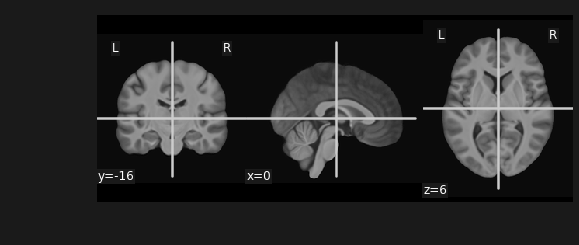

In [132]:
# load all subjects' anatomical data
anat = []
for sub in sub_num:
    anat.append(load_anat(sub))

# average and plot
anat_mean = mean_img(anat)
plotting.plot_anat(anat_mean)

29


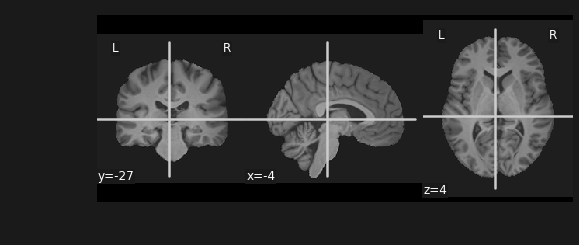

In [135]:
print(len(anat))

plotting.plot_anat(anat[1])


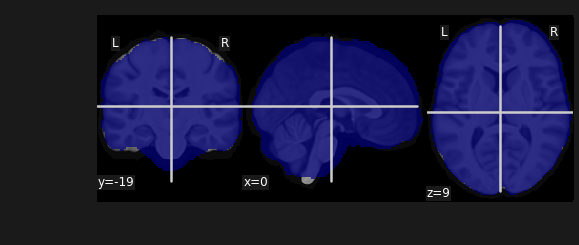

In [136]:
mask_whb = load_whb_mask(2073,2)
plotting.plot_roi(mask_whb, bg_img = anat_mean)

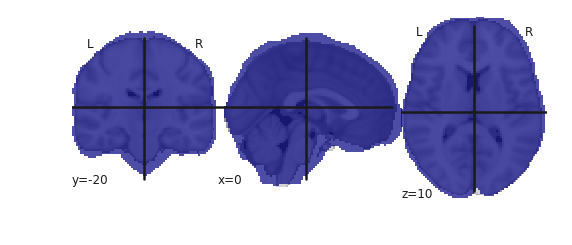

In [125]:
mask_whb = load_whb_mask(2588,5)
plotting.plot_roi(mask_whb)